# Betaflight System Identification

This notebook reads Betaflight blackbox logs (CSV format) and produces a JSON file of system identification parameters.

**Automatic Configuration Detection:**
The notebook automatically reads configuration parameters from the corresponding `.bbl` file:
- `minthrottle` - minimum throttle value
- `motorOutput` - motor output min/max range  
- `gyro_scale` - gyroscope scale factor
- `acc_1G` - accelerometer scale factor (units per 1G)

**Required CSV columns from blackbox log:**
- `time (us)` - timestamp in microseconds
- `gyroADC[0-2]` or `gyroUnfilt[0-2]` - gyro data (will be scaled using gyro_scale from .bbl)
- `accSmooth[0-2]` - accelerometer data (will be scaled using acc_1G from .bbl)
- `motor[0-3]` - motor outputs (will be normalized using motorOutput range from .bbl)
- `eRPM[0-3]` - (optional) actual motor RPM from ESC telemetry

**RPM-Based Estimation (if eRPM data available):**
1. Motor delay (T_m) is optimized using filtered motor commands
2. Filtered motor commands are compared to actual RPM to find scaling factor
3. Actual RPM (unfiltered) is used for final thrust and inertia estimation
4. This provides more accurate results than using filtered motor commands

**Output:**
- JSON file with thrust coefficients, inertia, motor time constants, etc.

In [142]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from scipy.optimize import nnls

## Configuration

Edit these parameters to match your quadcopter:

In [143]:
# Model configuration
model_name = "my_quad"  # Name for output files

# List your blackbox CSV files here
# These should be exported from Betaflight Blackbox Explorer
data_files = [
    '/home/miller/code/rl-betaflight/blackbox.01.csv',  # Edit these paths to match your log files
]

# Physical parameters - MUST be measured/known for your quad
mass = 0.036  # kg - total mass of quadcopter
arm_length = np.linalg.norm(np.array([0.028,0.028]))  # meters - distance from center to motor

# Inertia ratio (Izz / average of Ixx and Iyy) - typical range 1.5-2.5 for X-frame quads
inertia_ratio = 1.8

# Motor output normalization (fallback values if .bbl file not found)
# These will be automatically read from the .bbl file if available
motors_normalized = False
motor_pwm_min = 1000  # Fallback: only used if .bbl file is not found
motor_pwm_max = 2000  # Fallback: only used if .bbl file is not found

# Thrust curve polynomial exponents to try
exponents_thrust_curve = [[0, 1, 2]]

# Debug/output settings
dpi = 150
debug = False

In [144]:
# Build quadcopter model geometry

rotor_x = arm_length * np.cos(np.pi/4)  # 45 degree arms
rotor_y = arm_length * np.sin(np.pi/4)

model = {
    "gravity": 9.81,
    "mass": mass,
    "rotor_positions": np.array([
        [-rotor_x, -rotor_y, 0],  # Motor 1: Rear Right
        [ rotor_x, -rotor_y, 0],  # Motor 2: Front Right
        [-rotor_x,  rotor_y, 0],  # Motor 3: Rear Left
        [ rotor_x,  rotor_y, 0]   # Motor 4: Front Left
    ]),
    "rotor_thrust_directions": np.array([
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]
    ]),
    "rotor_torque_directions": np.array([
        [0, 0,  1],  # Motor 1: CCW (positive torque)
        [0, 0, -1],  # Motor 2: CW (negative torque)
        [0, 0, -1],  # Motor 3: CW (negative torque)
        [0, 0,  1]   # Motor 4: CCW (positive torque)
    ])
}

g = np.array([0, 0, -model["gravity"]])

## Step 0: Load Betaflight Blackbox CSV Data

In [145]:
import struct
from pathlib import Path

def parse_bbl_config(bbl_filepath):
    """Parse configuration from a Betaflight blackbox .bbl file."""
    config = {}
    
    try:
        with open(bbl_filepath, 'rb') as f:
            # Read first 1000 lines which typically contain all headers
            for _ in range(1000):
                line = f.readline()
                if not line or not line.startswith(b'H '):
                    if line.startswith(b'H'):
                        continue
                    else:
                        break
                
                # Decode and parse header line
                try:
                    line_str = line.decode('utf-8', errors='ignore').strip()
                    if line_str.startswith('H '):
                        parts = line_str[2:].split(':', 1)
                        if len(parts) == 2:
                            key, value = parts
                            config[key.strip()] = value.strip()
                except:
                    continue
        
        # Extract relevant parameters
        result = {}
        
        # Parse minthrottle
        if 'minthrottle' in config:
            result['minthrottle'] = int(config['minthrottle'])
        
        # Parse motorOutput (min, max)
        if 'motorOutput' in config:
            motor_output = config['motorOutput'].split(',')
            if len(motor_output) >= 2:
                result['motor_output_min'] = int(motor_output[0])
                result['motor_output_max'] = int(motor_output[1])
        
        # # Parse gyro_scale (it's stored as a hex float)
        # if 'gyro_scale' in config:
        #     gyro_scale_hex = config['gyro_scale']
        #     if gyro_scale_hex.startswith('0x'):
        #         # Convert hex to float
        #         hex_int = int(gyro_scale_hex, 16)
        #         gyro_scale_float = struct.unpack('!f', struct.pack('!I', hex_int))[0]
        #         result['gyro_scale'] = gyro_scale_float
        
        # Parse acc_1G (accelerometer scale factor)
        if 'acc_1G' in config:
            result['acc_1G'] = int(config['acc_1G'])
        
        return result
    
    except Exception as e:
        print(f"Warning: Could not parse .bbl file: {e}")
        return {}

def load_betaflight_csv(csv_filepath, bbl_config=None):
    """Load a Betaflight blackbox CSV file and convert to standard format."""
    df = pd.read_csv(csv_filepath, sep=', ')
    
    flight = {
        "name": csv_filepath,
        "data": {}
    }
    
    # Get timestamps - convert from microseconds to seconds
    if 'time (us)' in df.columns:
        timestamps = np.array(df['time (us)']) * 1e-6
    elif 'time' in df.columns:
        timestamps = np.array(df['time'])
    else:
        raise ValueError(f"No time column found in {csv_filepath}")
    
    # Determine accelerometer scale from bbl_config or use default
    if bbl_config and 'acc_1G' in bbl_config:
        acc_1G = bbl_config['acc_1G']
        accel_scale = 9.81 / acc_1G
        print(f"  Using acc_1G = {acc_1G} from .bbl file (scale = {accel_scale:.6f})")
    else:
        accel_scale = 9.81 / 256  # Default Betaflight acc_1G
        print(f"  Using default acc_1G = 256 (scale = {accel_scale:.6f})")
    
    # Load accelerometer data
    accel_cols = ['accSmooth[0]', 'accSmooth[1]', 'accSmooth[2]']
    if all(col in df.columns for col in accel_cols):
        flight["data"]["vehicle_acceleration_xyz[0]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[0]']) * accel_scale
        }
        flight["data"]["vehicle_acceleration_xyz[1]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[1]']) * accel_scale
        }
        flight["data"]["vehicle_acceleration_xyz[2]"] = {
            "timestamps": timestamps, 
            "values": np.array(df['accSmooth[2]']) * accel_scale
        }
    else:
        raise ValueError(f"Accelerometer columns not found in {csv_filepath}")
    
    # Determine gyro scale from bbl_config or use default
    if bbl_config and 'gyro_scale' in bbl_config:
        gyro_scale = bbl_config['gyro_scale'] * (np.pi / 180)  # gyro_scale is in deg/s per unit
        print(f"  Using gyro_scale = {bbl_config['gyro_scale']} from .bbl file")
    else:
        gyro_scale = np.pi / 180  # Default: assume deg/s
        print(f"  Using default gyro scale (assume deg/s)")
    
    # Load gyro data - prefer filtered (gyroADC) over unfiltered
    gyro_cols = ['gyroADC[0]', 'gyroADC[1]', 'gyroADC[2]']
    gyro_unfilt_cols = ['gyroUnfilt[0]', 'gyroUnfilt[1]', 'gyroUnfilt[2]']
    
    if all(col in df.columns for col in gyro_cols):
        gyro_source = gyro_cols
    elif all(col in df.columns for col in gyro_unfilt_cols):
        gyro_source = gyro_unfilt_cols
    else:
        raise ValueError(f"Gyro columns not found in {csv_filepath}")
    
    flight["data"]["vehicle_angular_velocity_xyz[0]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[0]]) * gyro_scale
    }
    flight["data"]["vehicle_angular_velocity_xyz[1]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[1]]) * gyro_scale
    }
    flight["data"]["vehicle_angular_velocity_xyz[2]"] = {
        "timestamps": timestamps, 
        "values": np.array(df[gyro_source[2]]) * gyro_scale
    }
    
    # Determine motor output range from bbl_config or use defaults
    if bbl_config and 'motor_output_min' in bbl_config and 'motor_output_max' in bbl_config:
        motor_min = bbl_config['motor_output_min']
        motor_max = bbl_config['motor_output_max']
        print(f"  Using motor output range [{motor_min}, {motor_max}] from .bbl file")
    else:
        motor_min = motor_pwm_min
        motor_max = motor_pwm_max
        print(f"  Using default motor output range [{motor_min}, {motor_max}]")
    
    # Load motor outputs
    motor_cols = ['motor[0]', 'motor[1]', 'motor[2]', 'motor[3]']
    if all(col in df.columns for col in motor_cols):
        for i, col in enumerate(motor_cols):
            motor_values = np.array(df[col])
            # Normalize to 0-1
            if not motors_normalized:
                motor_values = (motor_values - motor_min) / (motor_max - motor_min)
                motor_values = np.clip(motor_values, 0, 1)
            flight["data"][f"motor_control[{i}]"] = {
                "timestamps": timestamps,
                "values": motor_values
            }
    else:
        raise ValueError(f"Motor columns not found in {csv_filepath}")
    
    # Load eRPM data if available
    erpm_cols = ['eRPM[0]', 'eRPM[1]', 'eRPM[2]', 'eRPM[3]']
    if all(col in df.columns for col in erpm_cols):
        print(f"  Found eRPM columns - loading actual RPM data")
        for i, col in enumerate(erpm_cols):
            erpm_values = np.array(df[col])
            flight["data"][f"actual_rpm[{i}]"] = {
                "timestamps": timestamps,
                "values": erpm_values
            }
    else:
        print(f"  Warning: eRPM columns not found in CSV")
    
    return flight

# Load all flight data
flights = []
for csv_file in data_files:
    try:
        print(f"\nLoading {csv_file}...")
        
        # Try to find corresponding .bbl file
        csv_path = Path(csv_file)
        # Remove the .XX suffix if present (e.g., .01.csv -> .csv)
        base_name = csv_path.stem
        if '.' in base_name:
            base_name = base_name.rsplit('.', 1)[0]
        bbl_path = csv_path.parent / f"{base_name}.bbl"
        
        bbl_config = None
        if bbl_path.exists():
            print(f"  Found .bbl file: {bbl_path}")
            bbl_config = parse_bbl_config(bbl_path)
            if bbl_config:
                print(f"  Parsed .bbl config: {bbl_config}")
        else:
            print(f"  No .bbl file found at {bbl_path}, using defaults")
        
        flight = load_betaflight_csv(csv_file, bbl_config)
        flights.append(flight)
        print(f"  Loaded {len(flight['data']['vehicle_acceleration_xyz[0]']['timestamps'])} samples")
    except Exception as e:
        print(f"  Error loading {csv_file}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*60}")
print(f"Loaded {len(flights)} flight(s) total")
print(f"{'='*60}")


Loading /home/miller/code/rl-betaflight/blackbox.01.csv...
  Found .bbl file: /home/miller/code/rl-betaflight/blackbox.bbl
  Parsed .bbl config: {'minthrottle': 1070, 'motor_output_min': 1070, 'motor_output_max': 2000, 'acc_1G': 256}


/tmp/ipykernel_96387/2621638330.py:65: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_filepath, sep=', ')


  Using acc_1G = 256 from .bbl file (scale = 0.038320)
  Using default gyro scale (assume deg/s)
  Using motor output range [1070, 2000] from .bbl file
  Found eRPM columns - loading actual RPM data
  Loaded 113646 samples

Loaded 1 flight(s) total


## Step 0.5: Compare Estimated vs Actual RPM (After Motor Delay)

If eRPM data is available, we'll apply the motor delay to the estimated RPM, then compare it to actual RPM and auto-compute the scaling factor. The actual RPM will be used for final thrust/inertia calculations.

In [146]:
# Check if actual RPM data is available
has_rpm_data = all('actual_rpm[0]' in flight["data"] for flight in flights)

if has_rpm_data:
    print("eRPM data found - will use for final estimation after motor delay optimization")
else:
    print("No eRPM data found - will use filtered motor commands")

eRPM data found - will use for final estimation after motor delay optimization


## Step 1: Plot the Flights

<cell_type>markdown</cell_type>## Step 1.5: Plot Raw Gyro Data

Plot gyro measurements in degrees/s for all flights before any preprocessing or time windowing.

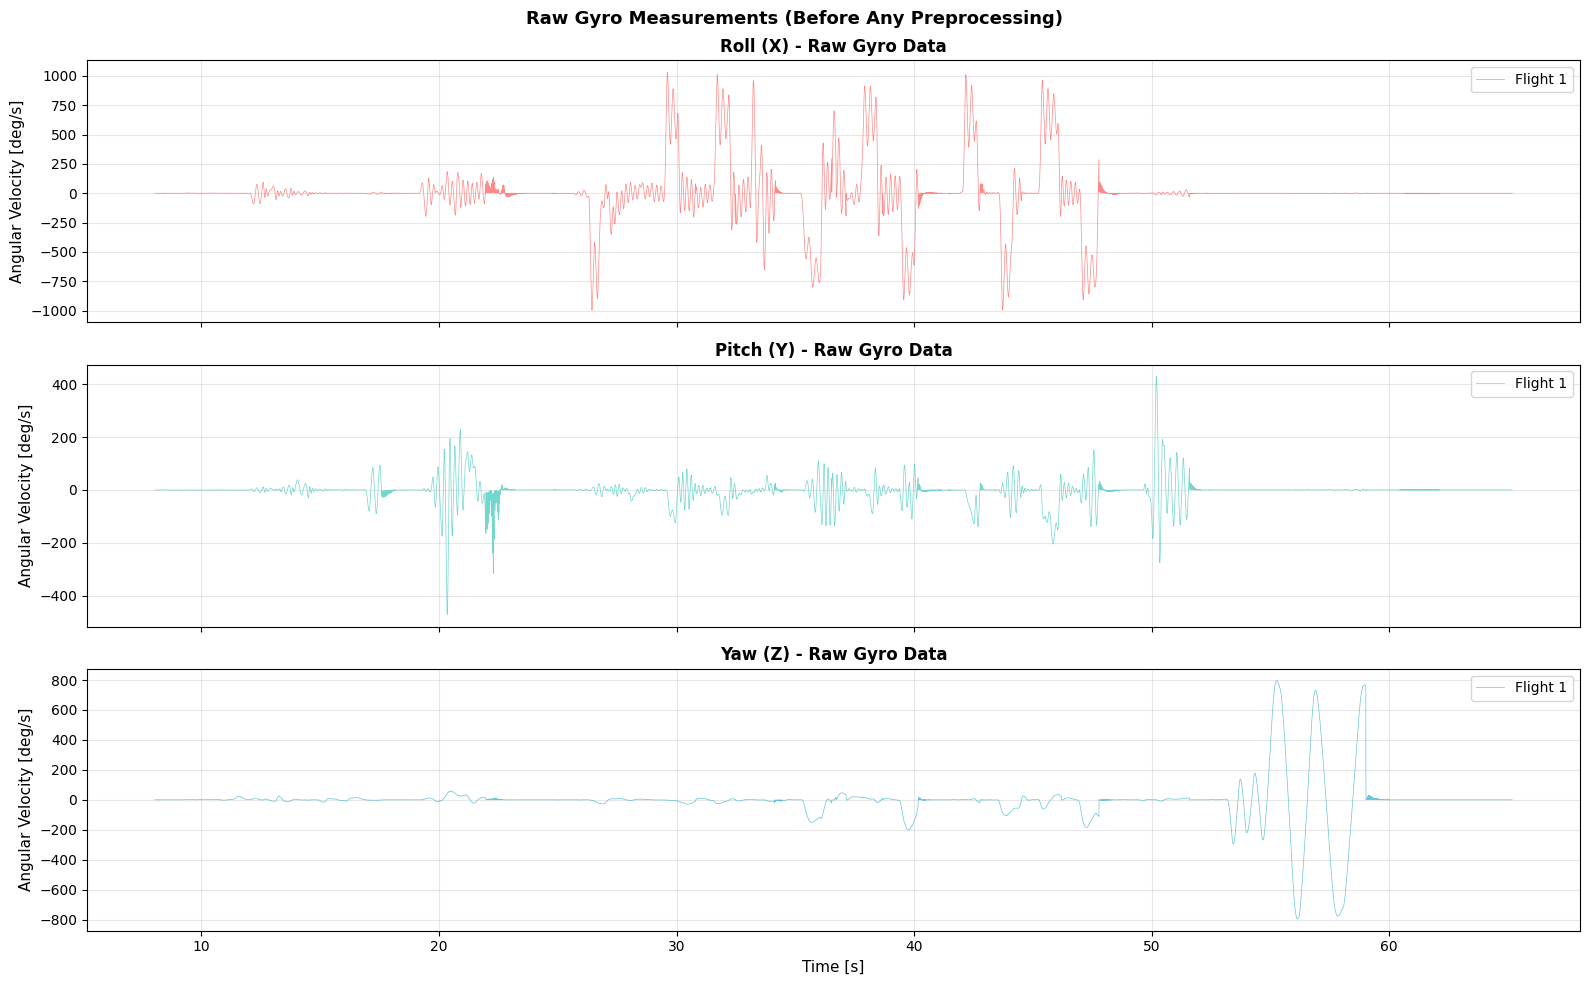

Raw Gyro Statistics (entire flight):
Roll (X):
  Min: -999.00 deg/s
  Max: 1032.00 deg/s
  Mean: 5.72 deg/s
  Std Dev: 234.40 deg/s
  RMS: 234.47 deg/s
Pitch (Y):
  Min: -471.00 deg/s
  Max: 429.00 deg/s
  Mean: -3.94 deg/s
  Std Dev: 45.22 deg/s
  RMS: 45.39 deg/s
Yaw (Z):
  Min: -795.00 deg/s
  Max: 796.00 deg/s
  Mean: -6.00 deg/s
  Std Dev: 153.89 deg/s
  RMS: 154.01 deg/s


In [147]:
# Plot raw gyro time series for all flights
fig, axs = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

axis_names = ['Roll (X)', 'Pitch (Y)', 'Yaw (Z)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for axis_i in range(3):
    ax = axs[axis_i]
    
    # Plot all loaded flights
    for flight_i, flight in enumerate(flights):
        omega = flight["data"][f"vehicle_angular_velocity_xyz[{axis_i}]"]["values"]
        timestamps = flight["data"][f"vehicle_angular_velocity_xyz[{axis_i}]"]["timestamps"]
        
        # Convert from rad/s to deg/s
        omega_deg = omega * (180 / np.pi)
        
        ax.plot(timestamps, omega_deg, alpha=0.8, linewidth=0.5, color=colors[axis_i], 
                label=f'Flight {flight_i + 1}' if flight_i == 0 else '')
    
    ax.set_ylabel(f'Angular Velocity [deg/s]', fontsize=11)
    ax.set_title(f'{axis_names[axis_i]} - Raw Gyro Data', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

axs[-1].set_xlabel('Time [s]', fontsize=11)
fig.suptitle('Raw Gyro Measurements (Before Any Preprocessing)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"figures/{model_name}_raw_gyro_timeseries.png", dpi=dpi)
plt.show()

# Print statistics for raw gyro data
print("Raw Gyro Statistics (entire flight):")
print("="*60)
for axis_i in range(3):
    omega_all = []
    for flight in flights:
        omega = flight["data"][f"vehicle_angular_velocity_xyz[{axis_i}]"]["values"]
        omega_all.extend(omega)
    
    omega_all = np.array(omega_all) * (180 / np.pi)  # Convert to deg/s
    
    print(f"{axis_names[axis_i]}:")
    print(f"  Min: {omega_all.min():.2f} deg/s")
    print(f"  Max: {omega_all.max():.2f} deg/s")
    print(f"  Mean: {omega_all.mean():.2f} deg/s")
    print(f"  Std Dev: {omega_all.std():.2f} deg/s")
    print(f"  RMS: {np.sqrt(np.mean(omega_all**2)):.2f} deg/s")
print("="*60)

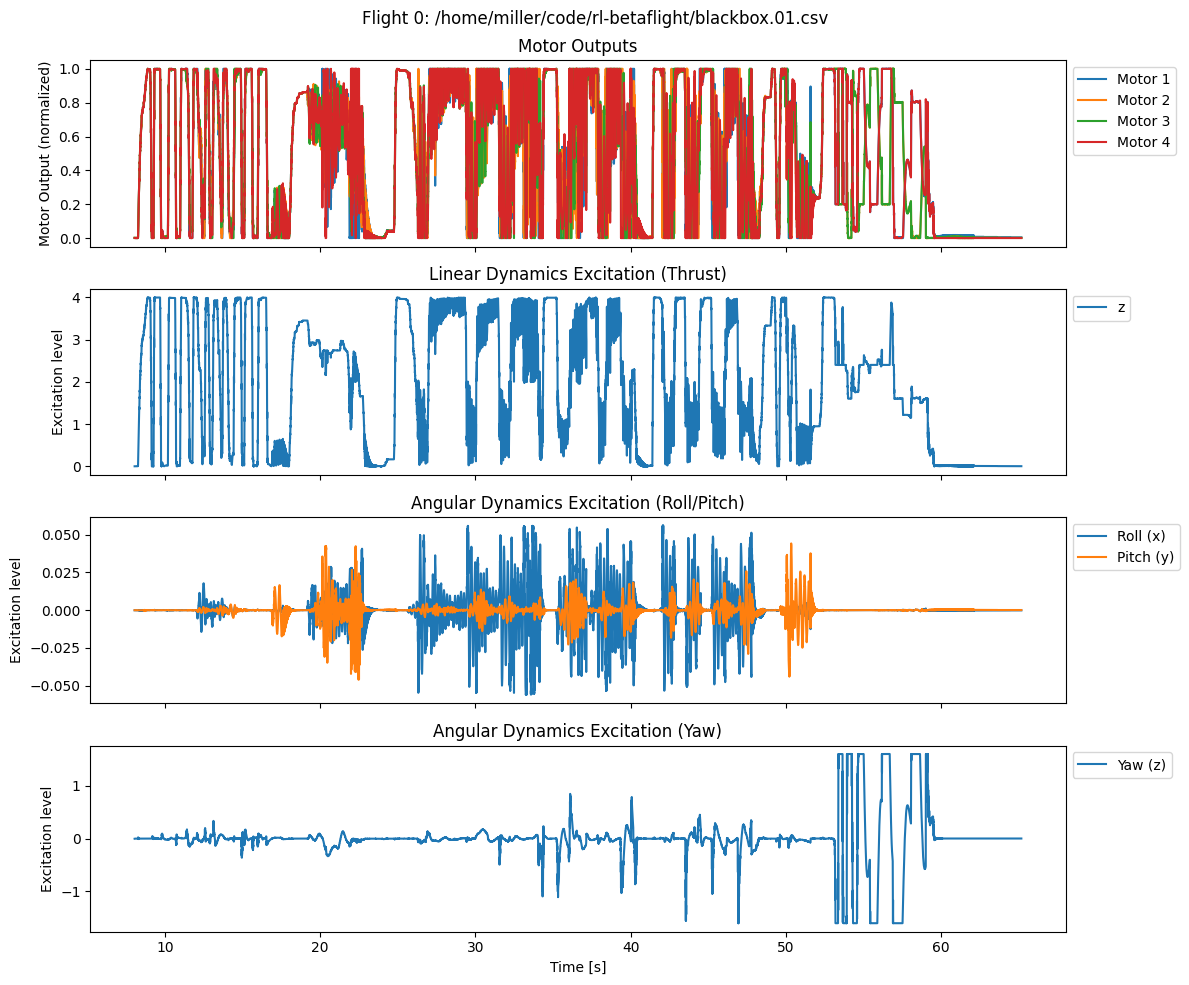

In [148]:
output_topic = "motor"

for flight_i, flight in enumerate(flights):
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    ax = 0
    for motor_i in range(4):
        key = f"motor_control[{motor_i}]"
        axs[ax].plot(flight["data"][key]["timestamps"], flight["data"][key]["values"], label=f"Motor {motor_i+1}")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Motor Output (normalized)')
    axs[ax].set_title('Motor Outputs')
    ax += 1
    
    # Calculate thrust and torque excitation
    thrust_values = []
    thrust_torque_values = []
    geometric_torque_values = []
    timestamps = flight["data"]["motor_control[0]"]["timestamps"]
    
    for motor_i in range(4):
        key = f"motor_control[{motor_i}]"
        motor_vals = flight["data"][key]["values"]
        thrust_values.append(motor_vals[:, np.newaxis] * model["rotor_thrust_directions"][motor_i][np.newaxis, :])
        thrust_torque_values.append(motor_vals[:, np.newaxis] * model["rotor_torque_directions"][motor_i][np.newaxis, :])
        geometric_torque_values.append(motor_vals[:, np.newaxis] * np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i])[np.newaxis, :])
    
    thrust_values = sum(thrust_values)
    thrust_torque_values = sum(thrust_torque_values)
    geometric_torque_values = sum(geometric_torque_values)

    axs[ax].set_title("Linear Dynamics Excitation (Thrust)")
    axs[ax].plot(timestamps, thrust_values[:, 2], label="z")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (Roll/Pitch)")
    axs[ax].plot(timestamps, geometric_torque_values[:, 0], label="Roll (x)")
    axs[ax].plot(timestamps, geometric_torque_values[:, 1], label="Pitch (y)")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (Yaw)")
    axs[ax].plot(timestamps, thrust_torque_values[:, 2], label="Yaw (z)")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[ax].set_ylabel('Excitation level')

    axs[-1].set_xlabel('Time [s]')
    fig.suptitle(f"Flight {flight_i}: {flight['name']}")
    plt.tight_layout()
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"figures/{model_name}_flight{flight_i}.png", dpi=dpi)
    plt.show()

## Step 2: Select Time Slices for System Identification

Select time ranges with good excitation for each identification task:
- **Thrust**: Vertical motion with varying throttle
- **Roll/Pitch Inertia**: Roll/pitch maneuvers 
- **Yaw Inertia**: Yaw maneuvers

In [149]:
# Edit these time ranges based on your flight data
# Look at the plots above to identify good excitation regions

timeframes_thrust = [
    {
        "flight": 0,
        "start": 0,  # seconds
        "end": 15
    }
]

timeframes_inertia_roll_pitch = [
    {
        "flight": 0,
        "start": 20,  # seconds
        "end": 50
    }
]

timeframes_inertia_yaw = [
    {
        "flight": 0,
        "start": 50,  # seconds
        "end": 60
    }
]

In [150]:
def extract_timeframes(flights, timeframes):
    """Extract time slices from flights."""
    output_flights = []
    fragment_counter = {}
    for timeframe in timeframes:
        flight = deepcopy(flights[timeframe["flight"]])
        fragment_id = fragment_counter.get(flight["name"], 0)
        fragment_counter[flight["name"]] = fragment_id + 1
        flight["name"] = flight["name"] + f".{fragment_id}"
        start, end = timeframe["start"], timeframe["end"]
        data = flight["data"]
        for series in data:
            mask = (data[series]["timestamps"] > start) & (data[series]["timestamps"] < end)
            data[series]["timestamps"] = data[series]["timestamps"][mask]
            data[series]["values"] = data[series]["values"][mask]
        output_flights.append(flight)
    return output_flights

flights_thrust = extract_timeframes(flights, timeframes_thrust)
flights_inertia_roll_pitch = extract_timeframes(flights, timeframes_inertia_roll_pitch)
flights_inertia_yaw = extract_timeframes(flights, timeframes_inertia_yaw)

print(f"Thrust timeframes: {len(flights_thrust)} segments")
print(f"Roll/Pitch inertia timeframes: {len(flights_inertia_roll_pitch)} segments")
print(f"Yaw inertia timeframes: {len(flights_inertia_yaw)} segments")

Thrust timeframes: 1 segments
Roll/Pitch inertia timeframes: 1 segments
Yaw inertia timeframes: 1 segments


## Step 3: Detect Gaps and Interpolate Data

In [151]:
def slice_gaps_and_interpolate(flights):
    """Handle gaps in data and interpolate to common timestamps."""
    flights_output = []
    for flight in flights:
        lowest_frequency = None
        lowest_frequency_name = None
        highest_frequency = None
        highest_frequency_name = None
        
        for name, data in flight["data"].items():
            diff = np.diff(data["timestamps"])
            if len(diff) == 0:
                continue
            frequency = 1/np.median(diff)
            if lowest_frequency is None or frequency < lowest_frequency:
                lowest_frequency = frequency
                lowest_frequency_name = name
            if highest_frequency is None or frequency > highest_frequency:
                highest_frequency = frequency
                highest_frequency_name = name

        if lowest_frequency is None:
            print(f"Skipping flight with no valid data")
            continue
            
        interval_threshold = 3 * 1/lowest_frequency
        print(f"Lowest frequency: {lowest_frequency:.1f} Hz for {lowest_frequency_name}")
        print(f"Highest frequency: {highest_frequency:.1f} Hz for {highest_frequency_name}")

        earliest_timestamp_all = max([data["timestamps"][0] for name, data in flight["data"].items() if len(data["timestamps"]) > 0])
        latest_timestamp_all = min([data["timestamps"][-1] for name, data in flight["data"].items() if len(data["timestamps"]) > 0])
        
        master_timestamps_full = flight["data"][highest_frequency_name]["timestamps"]
        master_timestamps = master_timestamps_full[(master_timestamps_full > earliest_timestamp_all) & (master_timestamps_full < latest_timestamp_all)]
        
        if len(master_timestamps) == 0:
            print(f"Skipping flight with no overlapping timestamps")
            continue
            
        earliest_timestamp = master_timestamps[0]
        latest_timestamp = master_timestamps[-1]
        total_time = latest_timestamp - earliest_timestamp

        # Find gaps
        gaps = []
        for name, data in flight["data"].items():
            current_timestamps_full = data["timestamps"]
            current_timestamps = current_timestamps_full[(current_timestamps_full > earliest_timestamp) & (current_timestamps_full < latest_timestamp)]
            current_timestamps_augmented = np.concatenate([[earliest_timestamp], current_timestamps, [latest_timestamp]])
            diff = np.diff(current_timestamps_augmented)
            current_gaps = np.where(diff > interval_threshold)[0]
            for gap in current_gaps:
                if gap < len(data["timestamps"]) - 1:
                    gap_start = data["timestamps"][gap]
                    gap_end = data["timestamps"][gap+1]
                    gaps.append((gap_start, gap_end))
        
        gaps_sorted = sorted(gaps, key=lambda x: x[0])

        # Combine overlapping gaps
        combined_gaps = []
        current_gap_start = None
        current_gap_end = None

        for i, (gap_start, gap_end) in enumerate(gaps_sorted):
            if current_gap_start is None:
                current_gap_start = gap_start
                current_gap_end = gap_end
            elif gap_start <= current_gap_end + interval_threshold:
                current_gap_end = max(current_gap_end, gap_end)
            else:
                combined_gaps.append((current_gap_start, current_gap_end))
                current_gap_start = gap_start
                current_gap_end = gap_end
        
        if current_gap_start is not None:
            combined_gaps.append((current_gap_start, current_gap_end))

        print(f"Number of gaps: {len(combined_gaps)}")
        
        total_gap_time = sum([gap_end - gap_start for gap_start, gap_end in combined_gaps])
        if total_gap_time >= 0.1 * total_time:
            print(f"Warning: Total gap time {total_gap_time:.2f}s is >= 10% of total time")

        # Create subflights from continuous segments
        subflights = []
        current_segment_start_timestamp = earliest_timestamp
        for gap_start, gap_end in [*combined_gaps, (latest_timestamp, latest_timestamp)]:
            segment_time = gap_start - current_segment_start_timestamp
            if segment_time > 0.01 * total_time:
                current_segment_timestamps = master_timestamps[(master_timestamps > current_segment_start_timestamp) & (master_timestamps < gap_start)]
                sub_flight = {
                    name: {
                        "timestamps": current_segment_timestamps,
                        "values": np.interp(current_segment_timestamps, data["timestamps"], data["values"])
                    } for name, data in flight["data"].items()
                }
                subflights.append(sub_flight)
            current_segment_start_timestamp = gap_end
        
        print(f"Number of subflights: {len(subflights)}")

        for subflight_i, subflight in enumerate(subflights):
            flights_output.append({
                "name": flight["name"] + f"_{subflight_i}",
                "timestamps": subflight[highest_frequency_name]["timestamps"],
                "data": subflight
            })
    return flights_output

In [152]:
print("Processing thrust data...")
sliced_and_interpolated_flights_thrust = slice_gaps_and_interpolate(flights_thrust)
print("\nProcessing roll/pitch inertia data...")
sliced_and_interpolated_flights_inertia_roll_pitch = slice_gaps_and_interpolate(flights_inertia_roll_pitch)
print("\nProcessing yaw inertia data...")
sliced_and_interpolated_flights_inertia_yaw = slice_gaps_and_interpolate(flights_inertia_yaw)

Processing thrust data...
Lowest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 15
Number of subflights: 11

Processing roll/pitch inertia data...
Lowest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 45
Number of subflights: 23

Processing yaw inertia data...
Lowest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Highest frequency: 1988.1 Hz for vehicle_acceleration_xyz[0]
Number of gaps: 23
Number of subflights: 11


## Step 4: Apply Motor Delay Filter and Combine Data

In [153]:
def filter_ema(timestamps, values, T_m):
    """Apply exponential moving average filter to model motor delay."""
    filtered = []
    current = None
    previous_t = None
    for t, value in zip(timestamps, values):
        if current is None:
            current = value
        else:
            delta_t = t - previous_t
            alpha = np.exp(-delta_t / T_m)
            current = alpha * current + (1 - alpha) * value
        filtered.append(current)
        previous_t = t
    return np.array(filtered)

def filter_ema_directional(timestamps, values, T_m_rising, T_m_falling):
    """Apply exponential moving average filter with direction-dependent time constants.
    
    Handles vectorized input where values can be either 1D (single signal) or 2D (multiple signals).

    Args:
        timestamps: Time array [s]
        values: Input signal - either 1D (N samples,) or 2D (N samples, M channels)
        T_m_rising: Time constant for rising (increasing) signals [s]
        T_m_falling: Time constant for falling (decreasing) signals [s]

    Returns:
        filtered: Filtered signal array (same shape as input)
    """
    values = np.asarray(values)
    is_1d = values.ndim == 1
    
    if is_1d:
        values = values[:, np.newaxis]
    
    n_samples, n_channels = values.shape
    filtered = np.zeros_like(values)
    current = values[0].copy()
    previous_t = None
    
    for i in range(n_samples):
        if i == 0:
            filtered[i] = current
            previous_t = timestamps[i]
        else:
            delta_t = timestamps[i] - previous_t
            
            # Determine direction for each channel
            # value > previous_value → rising, use T_m_rising
            # value <= previous_value → falling, use T_m_falling
            direction = values[i] > values[i-1]  # Boolean array per channel
            T_m_array = np.where(direction, T_m_rising, T_m_falling)
            
            alpha = np.exp(-delta_t / T_m_array)
            current = alpha * current + (1 - alpha) * values[i]
            filtered[i] = current
            
            previous_t = timestamps[i]
    
    return filtered[:, 0] if is_1d else filtered

def combine(flights, T_m_rising=None, T_m_falling=None, T_m=None, thrust_curves=None, use_actual_rpm=False):
    """Combine flight data with motor delay filtering.
    
    Args:
        flights: List of flight data dictionaries
        T_m_rising: Rising time constant (if None, uses T_m)
        T_m_falling: Falling time constant (if None, uses T_m)
        T_m: Symmetric time constant (backward compatibility)
        thrust_curves: Optional thrust curve coefficients
        use_actual_rpm: If True and RPM data available, use actual RPM (un-normalized) instead of filtered motor commands
    """
    # Handle backward compatibility
    if T_m_rising is None or T_m_falling is None:
        if T_m is None:
            raise ValueError("Must provide either T_m or both T_m_rising and T_m_falling")
        T_m_rising = T_m
        T_m_falling = T_m
    
    for flight in flights:
        timestamps = flight["timestamps"]
        
        # Get motor setpoints
        motor_setpoints = np.array([flight["data"][f"motor_control[{i}]"]["values"] for i in range(4)]).T

        # Check if we should use actual RPM data
        has_rpm = all(f"actual_rpm[{i}]" in flight["data"] for i in range(4))
        
        if use_actual_rpm and has_rpm:
            # Use actual RPM data directly (un-normalized)
            # NO filtering applied to actual RPM - it's already the real measurement
            motors = np.array([flight["data"][f"actual_rpm[{i}]"]["values"] for i in range(4)]).T
        else:
            # Use directional filter with both time constants (vectorized per motor)
            motors = filter_ema_directional(timestamps, motor_setpoints, T_m_rising, T_m_falling)
        
        # Get acceleration and convert frame if needed
        acceleration_original = np.array([flight["data"][f"vehicle_acceleration_xyz[{i}]"]["values"] for i in range(3)]).T
        acceleration = acceleration_original
        
        # Get angular velocity and convert frame if needed
        omega = np.array([flight["data"][f"vehicle_angular_velocity_xyz[{i}]"]["values"] for i in range(3)]).T
        
        # Compute angular acceleration from gyro data
        domega = np.gradient(omega, timestamps, axis=0)
        
        flight["motor_setpoints"] = motor_setpoints
        flight["motors"] = motors
        flight["acceleration"] = acceleration
        flight["omega"] = omega
        flight["domega"] = domega
        
        if thrust_curves is not None:
            def apply_thrust_curves(motors, thrust_curves):
                thrusts = []
                for thrust_curve, motor in zip(thrust_curves, motors):
                    thrust = sum(coeff * motor**exp for exp, coeff in enumerate(thrust_curve))
                    thrusts.append(thrust)
                return np.array(thrusts)
            
            flight["thrusts"] = np.array([apply_thrust_curves(motors, thrust_curves) for motors in flight["motors"]])
            motor_thrust_to_torque_geometric = np.array([np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i]) for motor_i in range(4)])
            flight["pre_torque"] = flight["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
            flight["pre_torque_geometric"] = flight["thrusts"][:, :, np.newaxis] * motor_thrust_to_torque_geometric
    
    thrusts_combined = {}
    if thrust_curves is not None:
        thrusts_combined = {
            "thrusts": np.concatenate([flight["thrusts"] for flight in flights]),
            "pre_torque": np.concatenate([flight["pre_torque"] for flight in flights]),
            "pre_torque_geometric": np.concatenate([flight["pre_torque_geometric"] for flight in flights]),
        }

    return {
        "motor_setpoints": np.concatenate([flight["motor_setpoints"] for flight in flights]),
        "motors": np.concatenate([flight["motors"] for flight in flights]),
        "acceleration": np.concatenate([flight["acceleration"] for flight in flights]),
        "omega": np.concatenate([flight["omega"] for flight in flights]),
        "domega": np.concatenate([flight["domega"] for flight in flights]),
        **thrusts_combined
    }, flights

In [154]:
# Test with initial motor time constant
T_m_test = 0.05
combined_test, _ = combine(sliced_and_interpolated_flights_thrust, T_m=T_m_test)
print(f"Combined data shape: {combined_test['acceleration'].shape}")

Combined data shape: (13732, 3)


## Step 5: Estimate Motor Parameters

In [155]:
def estimate_motor_parameters(combined, model, exponents, verbose=True, separate=True):
    """Estimate thrust curve coefficients using non-negative least squares.
    
    Enforces that all thrust coefficients are >= 0, which is physically required
    since thrust increases monotonically with motor speed.
    """
    b = []
    A = []
    num_steps = len(combined["motors"])
    
    for step_i in range(num_steps):
        acceleration = combined["acceleration"][step_i]
        b.append(model["mass"] * acceleration)
        current_A = []
        motor = combined["motors"][step_i]
        
        if separate:
            for motor_i in range(4):
                for exponent in exponents:
                    current_A.append(model["rotor_thrust_directions"][motor_i] * motor[motor_i] ** exponent)
        else:
            for exponent in exponents:
                acc = np.zeros(3)
                for motor_i in range(4):
                    acc += model["rotor_thrust_directions"][motor_i] * motor[motor_i] ** exponent
                current_A.append(acc)
        A.append(np.array(current_A).T)

    A = np.array(A).reshape(-1, (4 if separate else 1) * len(exponents))
    b = np.array(b).reshape(-1)
    
    if verbose:
        print(f"A shape: {A.shape}")
        print(f"b shape: {b.shape}")
    
    # Use Non-Negative Least Squares to enforce K_f >= 0
    K_f_flat, residual = nnls(A, b)
    K_f = K_f_flat.reshape(-1, len(exponents))
    
    rmse = np.sqrt(np.mean((A @ K_f_flat - b) ** 2))
    
    if separate:
        K_f_full = np.array([[K_f[motor_i][exponents.index(i)] if i in exponents else 0 for i in range(3)] for motor_i in range(4)])
    else:
        K_f_full = np.array([[K_f[0][exponents.index(i)] if i in exponents else 0 for i in range(3)] for _ in range(4)])
    
    if verbose:
        print(f"Thrust coefficients (NNLS, all >= 0): {K_f_full[0]}")
    
    return K_f_full, rmse

Estimating motor time constants directly from RPM data
Estimated RPM scale factor: 21283.9 RPM per unit command
Rising samples: 1322
Falling samples: 1364

Optimal motor time constants (direct least squares):
  T_m_rising:  0.0834 s
  T_m_falling: 0.2842 s
  Asymmetry ratio (falling/rising): 3.41


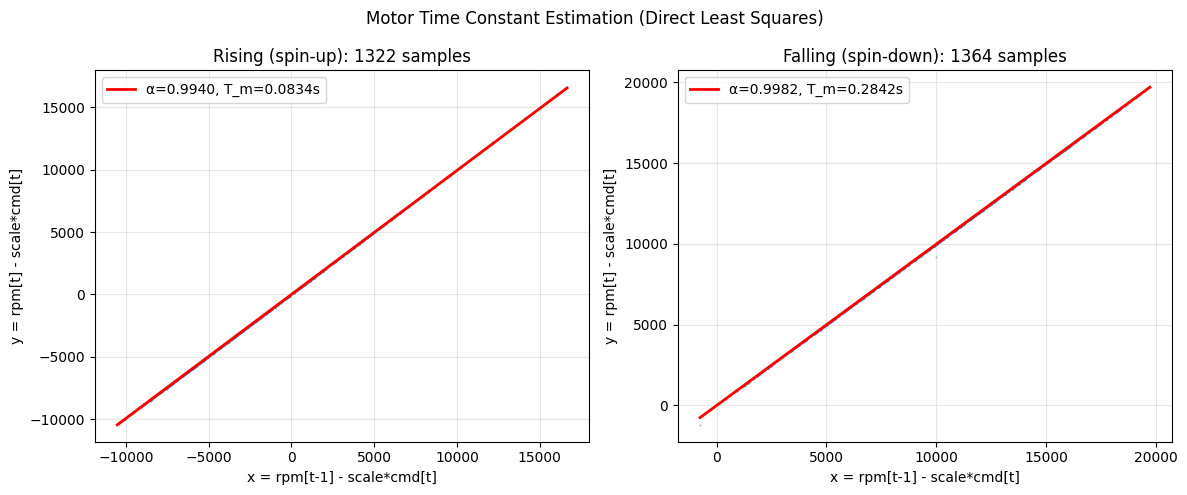

In [156]:
# Estimate motor time constants directly from RPM data using least squares
# The EMA filter relationship: rpm[t] = α * rpm[t-1] + (1-α) * command[t] * scale
# Where α = exp(-dt / T_m)
# 
# Rearranging: rpm[t] - command[t]*scale = α * (rpm[t-1] - command[t]*scale)
# This is linear in α for each sample, so we can estimate α via least squares

if has_rpm_data:
    print("="*60)
    print("Estimating motor time constants directly from RPM data")
    print("="*60)
    
    # Collect all motor command and RPM data
    all_commands = []
    all_rpms = []
    all_timestamps = []
    
    for flight in sliced_and_interpolated_flights_thrust:
        timestamps = flight["timestamps"]
        for motor_i in range(4):
            commands = flight["data"][f"motor_control[{motor_i}]"]["values"]
            rpms = flight["data"][f"actual_rpm[{motor_i}]"]["values"]
            all_commands.append(commands)
            all_rpms.append(rpms)
            all_timestamps.append(timestamps)
    
    all_commands = np.concatenate(all_commands)
    all_rpms = np.concatenate(all_rpms)
    all_timestamps = np.concatenate(all_timestamps)
    
    # Compute time differences
    dt = np.diff(all_timestamps)
    
    # Compute command changes to classify rising vs falling
    d_command = np.diff(all_commands)
    
    # Get consecutive RPM pairs
    rpm_prev = all_rpms[:-1]
    rpm_curr = all_rpms[1:]
    cmd_curr = all_commands[1:]
    
    # First estimate the scale factor (RPM per unit command)
    # At steady state: rpm = scale * command
    # Use high-command samples where dynamics are settled
    steady_mask = (np.abs(d_command) < 0.01) & (all_commands[:-1] > 0.3)
    if steady_mask.sum() > 100:
        scale = np.median(rpm_curr[steady_mask] / cmd_curr[steady_mask])
    else:
        scale = np.median(all_rpms[all_commands > 0.1] / all_commands[all_commands > 0.1])
    print(f"Estimated RPM scale factor: {scale:.1f} RPM per unit command")
    
    # Now estimate α for rising and falling separately
    # EMA: rpm[t] = α * rpm[t-1] + (1-α) * scale * cmd[t]
    # Rearrange: rpm[t] - scale*cmd[t] = α * (rpm[t-1] - scale*cmd[t])
    # Let y = rpm[t] - scale*cmd[t], x = rpm[t-1] - scale*cmd[t]
    # Then y = α * x, solve via least squares
    
    y = rpm_curr - scale * cmd_curr
    x = rpm_prev - scale * cmd_curr
    
    # Filter for valid samples (avoid division issues and low-signal samples)
    valid = (np.abs(x) > 100) & (rpm_curr > 100) & (dt > 0)
    
    # Split into rising and falling
    rising_mask = valid & (d_command > 0.01)
    falling_mask = valid & (d_command < -0.01)
    
    print(f"Rising samples: {rising_mask.sum()}")
    print(f"Falling samples: {falling_mask.sum()}")
    
    # Least squares for α: y = α * x  →  α = (x·y) / (x·x)
    if rising_mask.sum() > 10:
        alpha_rising = np.sum(x[rising_mask] * y[rising_mask]) / np.sum(x[rising_mask]**2)
        # Clamp alpha to valid range
        alpha_rising = np.clip(alpha_rising, 0.01, 0.999)
        # Convert to time constant: α = exp(-dt/T_m) → T_m = -dt / ln(α)
        dt_median_rising = np.median(dt[rising_mask])
        T_m_rising = -dt_median_rising / np.log(alpha_rising)
    else:
        print("Warning: Not enough rising samples, using default")
        T_m_rising = 0.1
    
    if falling_mask.sum() > 10:
        alpha_falling = np.sum(x[falling_mask] * y[falling_mask]) / np.sum(x[falling_mask]**2)
        alpha_falling = np.clip(alpha_falling, 0.01, 0.999)
        dt_median_falling = np.median(dt[falling_mask])
        T_m_falling = -dt_median_falling / np.log(alpha_falling)
    else:
        print("Warning: Not enough falling samples, using default")
        T_m_falling = 0.1
    
    # Clamp to reasonable range
    T_m_rising = np.clip(T_m_rising, 0.001, 0.5)
    T_m_falling = np.clip(T_m_falling, 0.001, 0.5)
    
    print(f"\nOptimal motor time constants (direct least squares):")
    print(f"  T_m_rising:  {T_m_rising:.4f} s")
    print(f"  T_m_falling: {T_m_falling:.4f} s")
    print(f"  Asymmetry ratio (falling/rising): {T_m_falling/T_m_rising:.2f}")
    
    # Visualize the fit
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Rising
    ax = axs[0]
    if rising_mask.sum() > 0:
        ax.scatter(x[rising_mask], y[rising_mask], s=0.5, alpha=0.3)
        x_range = np.array([x[rising_mask].min(), x[rising_mask].max()])
        ax.plot(x_range, alpha_rising * x_range, 'r-', linewidth=2, 
                label=f'α={alpha_rising:.4f}, T_m={T_m_rising:.4f}s')
    ax.set_xlabel('x = rpm[t-1] - scale*cmd[t]')
    ax.set_ylabel('y = rpm[t] - scale*cmd[t]')
    ax.set_title(f'Rising (spin-up): {rising_mask.sum()} samples')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Falling
    ax = axs[1]
    if falling_mask.sum() > 0:
        ax.scatter(x[falling_mask], y[falling_mask], s=0.5, alpha=0.3)
        x_range = np.array([x[falling_mask].min(), x[falling_mask].max()])
        ax.plot(x_range, alpha_falling * x_range, 'r-', linewidth=2,
                label=f'α={alpha_falling:.4f}, T_m={T_m_falling:.4f}s')
    ax.set_xlabel('x = rpm[t-1] - scale*cmd[t]')
    ax.set_ylabel('y = rpm[t] - scale*cmd[t]')
    ax.set_title(f'Falling (spin-down): {falling_mask.sum()} samples')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Motor Time Constant Estimation (Direct Least Squares)')
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_motor_time_constants_ls.png", dpi=dpi)
    plt.show()

else:
    print("No RPM data - cannot estimate time constants directly")
    print("Falling back to grid search...")
    # Would need to implement grid search fallback here if needed
    T_m_rising = 0.1
    T_m_falling = 0.1

In [157]:
# Estimate thrust coefficients using actual RPM data
if has_rpm_data:
    print("="*60)
    print("Estimating thrust coefficients using ACTUAL RPM data")
    print("="*60)
    
    # Combine with actual RPM (un-normalized) to get motor values from real RPM
    combined_rpm, _ = combine(
        sliced_and_interpolated_flights_thrust,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling,
        use_actual_rpm=True
    )
    
    # Compute max measured RPM across all motors and flights
    max_measured_rpm = combined_rpm["motors"].max()
    print(f"Max measured RPM: {max_measured_rpm:.0f}")
    
    # Estimate thrust coefficients with actual RPM (un-normalized)
    K_f, rmse = estimate_motor_parameters(
        combined_rpm, model, exponents_thrust_curve[0], 
        verbose=True, separate=False
    )
    K_f_mean = K_f.mean(axis=0)
    
    print(f"\nThrust coefficients (from actual RPM): {K_f_mean}")
    print(f"RMSE: {rmse:.6f} N")
    
else:
    print("="*60)
    print("No RPM data available - using filtered motor commands")
    print("="*60)
    
    combined_filtered, _ = combine(
        sliced_and_interpolated_flights_thrust,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling
    )
    
    K_f, rmse = estimate_motor_parameters(
        combined_filtered, model, exponents_thrust_curve[0],
        verbose=True, separate=False
    )
    K_f_mean = K_f.mean(axis=0)
    max_measured_rpm = None
    
    print(f"\nThrust coefficients: {K_f_mean}")
    print(f"RMSE: {rmse:.6f}")

# Now recombine with final thrust curves for downstream estimation
thrust_curves = np.array([K_f_mean for _ in range(4)])

if has_rpm_data:
    combined_thrust, flights_thrust_processed = combine(
        sliced_and_interpolated_flights_thrust,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling,
        thrust_curves=thrust_curves,
        use_actual_rpm=True
    )
    combined_inertia_roll_pitch, flights_inertia_roll_pitch_processed = combine(
        sliced_and_interpolated_flights_inertia_roll_pitch,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling,
        thrust_curves=thrust_curves,
        use_actual_rpm=True
    )
    combined_inertia_yaw, flights_inertia_yaw_processed = combine(
        sliced_and_interpolated_flights_inertia_yaw,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling,
        thrust_curves=thrust_curves,
        use_actual_rpm=True
    )
else:
    combined_thrust, flights_thrust_processed = combine(
        sliced_and_interpolated_flights_thrust,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling,
        thrust_curves=thrust_curves
    )
    combined_inertia_roll_pitch, flights_inertia_roll_pitch_processed = combine(
        sliced_and_interpolated_flights_inertia_roll_pitch,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling,
        thrust_curves=thrust_curves
    )
    combined_inertia_yaw, flights_inertia_yaw_processed = combine(
        sliced_and_interpolated_flights_inertia_yaw,
        T_m_rising=T_m_rising,
        T_m_falling=T_m_falling,
        thrust_curves=thrust_curves
    )

Estimating thrust coefficients using ACTUAL RPM data
Max measured RPM: 21679
A shape: (41196, 3)
b shape: (41196,)
Thrust coefficients (NNLS, all >= 0): [2.75119581e-03 1.69903887e-06 1.81693898e-10]

Thrust coefficients (from actual RPM): [2.75119581e-03 1.69903887e-06 1.81693898e-10]
RMSE: 0.026683 N


## Step 5.5: Compare Filtered Motor Commands to Actual RPM (with optimal T_m)

Now that we have the optimal motor time constant, compare the delayed/filtered motor commands to actual RPM.

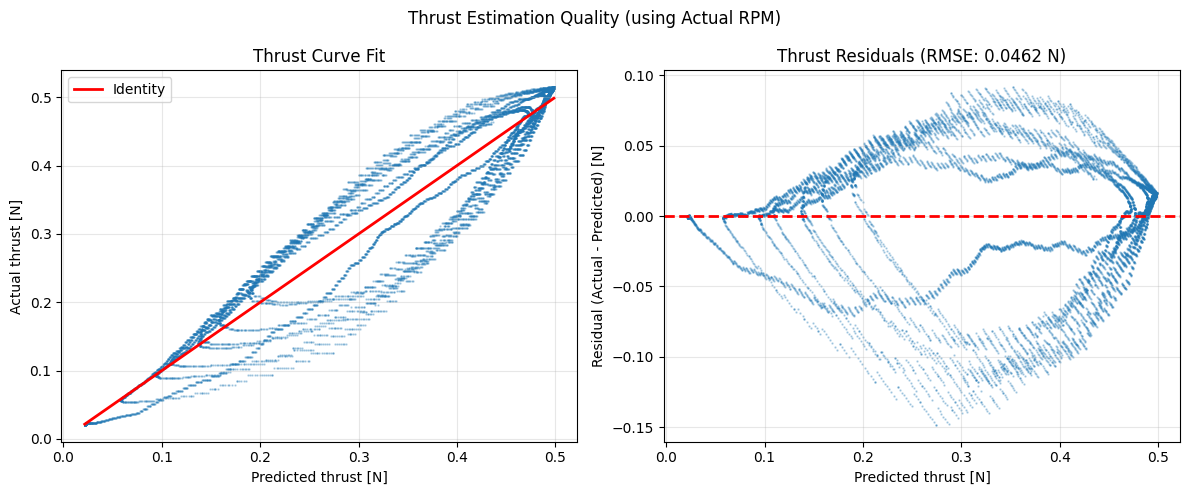

Thrust estimation RMSE: 0.0462 N
Mean absolute error: 0.0356 N
Data source: Actual RPM


In [158]:
# Plot thrust fit quality
predicted_thrust = combined_thrust["thrusts"].sum(axis=1)
actual_thrust = combined_thrust["acceleration"][:, 2] * model["mass"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
ax = axs[0]
ax.scatter(predicted_thrust, actual_thrust, s=0.5, alpha=0.3)
ax.plot([predicted_thrust.min(), predicted_thrust.max()], 
         [predicted_thrust.min(), predicted_thrust.max()], 
         linewidth=2, color="red", label="Identity")
ax.set_xlabel("Predicted thrust [N]")
ax.set_ylabel("Actual thrust [N]")
ax.legend()
ax.set_title("Thrust Curve Fit")
ax.grid(True, alpha=0.3)

# Residuals plot
ax = axs[1]
residuals = actual_thrust - predicted_thrust
ax.scatter(predicted_thrust, residuals, s=0.5, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel("Predicted thrust [N]")
ax.set_ylabel("Residual (Actual - Predicted) [N]")
rmse = np.sqrt(np.mean(residuals**2))
ax.set_title(f"Thrust Residuals (RMSE: {rmse:.4f} N)")
ax.grid(True, alpha=0.3)

data_source = "Actual RPM" if has_rpm_data else "Filtered Motor Commands"
fig.suptitle(f"Thrust Estimation Quality (using {data_source})")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_thrust_fit.png", dpi=dpi)
plt.show()

print(f"Thrust estimation RMSE: {rmse:.4f} N")
print(f"Mean absolute error: {np.mean(np.abs(residuals)):.4f} N")
print(f"Data source: {data_source}")

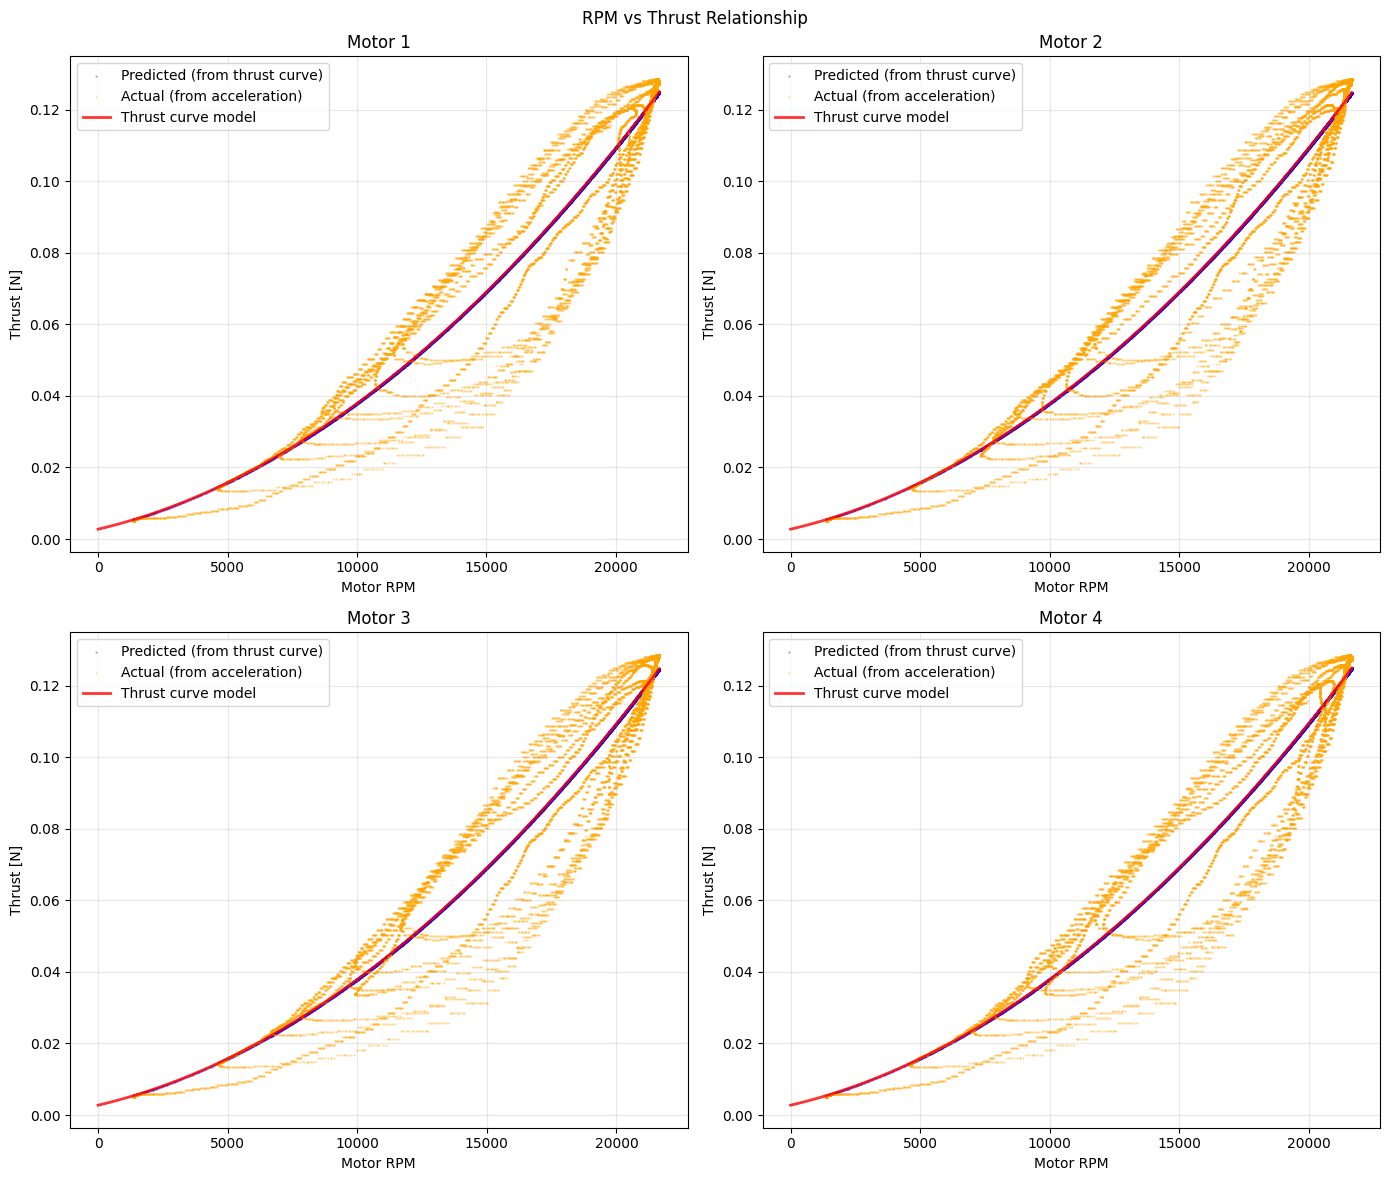

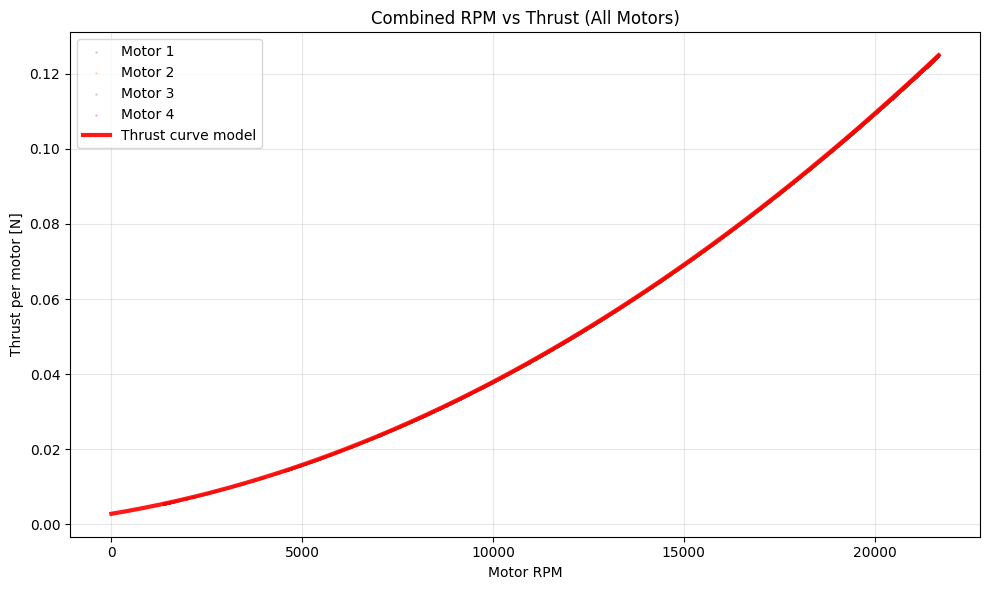


Thrust curve model (RPM in actual units):
T = 2.751196e-03 + 1.699039e-06*RPM^1 + 1.816939e-10*RPM^2
Max measured RPM: 21679


In [159]:
# Plot RPM vs Thrust relationship (if RPM data available)
if has_rpm_data:
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Get the motor data used in estimation (actual RPM, un-normalized)
    motors_data = combined_thrust["motors"]  # This is actual RPM (un-normalized)
    thrust_per_motor = combined_thrust["thrusts"]  # Predicted thrust per motor
    
    # Also get actual thrust from acceleration
    actual_total_thrust = combined_thrust["acceleration"][:, 2] * model["mass"]
    
    for motor_i in range(4):
        ax = axs[motor_i // 2, motor_i % 2]
        
        # Get actual RPM values
        motor_rpm = motors_data[:, motor_i]
        
        # Get predicted thrust for this motor
        predicted_motor_thrust = thrust_per_motor[:, motor_i]
        
        # Estimate "actual" thrust per motor by distributing total thrust equally
        # (This is an approximation since we can't measure individual motor thrust)
        estimated_actual_motor_thrust = actual_total_thrust / 4.0
        
        # Plot predicted thrust curve
        ax.scatter(motor_rpm, predicted_motor_thrust, 
                  s=0.5, alpha=0.3, label='Predicted (from thrust curve)', color='blue')
        
        # Plot "actual" thrust (from measured acceleration)
        ax.scatter(motor_rpm, estimated_actual_motor_thrust, 
                  s=0.5, alpha=0.3, label='Actual (from acceleration)', color='orange')
        
        # Plot the theoretical thrust curve
        rpm_range = np.linspace(0, motor_rpm.max(), 100)
        thrust_curve_plot = sum(K_f_mean[exp] * rpm_range**exp for exp in range(len(K_f_mean)))
        ax.plot(rpm_range, thrust_curve_plot, 'r-', linewidth=2, 
               label='Thrust curve model', alpha=0.8)
        
        ax.set_xlabel('Motor RPM')
        ax.set_ylabel('Thrust [N]')
        ax.set_title(f'Motor {motor_i + 1}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    fig.suptitle('RPM vs Thrust Relationship')
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_rpm_vs_thrust.png", dpi=dpi)
    plt.show()
    
    # Also create a combined plot showing all motors together
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for motor_i in range(4):
        motor_rpm = motors_data[:, motor_i]
        predicted_motor_thrust = thrust_per_motor[:, motor_i]
        
        # Subsample for clearer visualization
        subsample_indices = np.random.choice(len(motor_rpm), min(5000, len(motor_rpm)), replace=False)
        
        ax.scatter(motor_rpm[subsample_indices], predicted_motor_thrust[subsample_indices], 
                  s=1, alpha=0.2, label=f'Motor {motor_i + 1}')
    
    # Plot the theoretical curve
    rpm_range = np.linspace(0, motors_data.max(), 200)
    thrust_curve_plot = sum(K_f_mean[exp] * rpm_range**exp for exp in range(len(K_f_mean)))
    ax.plot(rpm_range, thrust_curve_plot, 'r-', linewidth=3, 
           label='Thrust curve model', alpha=0.9)
    
    ax.set_xlabel('Motor RPM')
    ax.set_ylabel('Thrust per motor [N]')
    ax.set_title('Combined RPM vs Thrust (All Motors)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_rpm_vs_thrust_combined.png", dpi=dpi)
    plt.show()
    
    # Print the thrust curve equation
    print("\nThrust curve model (RPM in actual units):")
    equation = "T = "
    for exp, coeff in enumerate(K_f_mean):
        if exp == 0:
            equation += f"{coeff:.6e}"
        else:
            sign = "+" if coeff >= 0 else "-"
            equation += f" {sign} {abs(coeff):.6e}*RPM^{exp}"
    print(equation)
    print(f"Max measured RPM: {max_measured_rpm:.0f}")
    
else:
    print("No RPM data available - skipping RPM vs thrust plots")

## Step 6: Estimate Inertia (Roll and Pitch)

<cell_type>markdown</cell_type>## Step 5.9: RANSAC-Based Inertia Estimation Function

Robust outlier rejection using Random Sample Consensus for inertia estimation.

In [160]:
def estimate_inertia_ransac(alpha, torque, iterations=1000, threshold_factor=2.5, min_alpha=1e-2):
    """
    Estimate inertia using RANSAC for robust outlier rejection.

    Args:
        alpha: Angular acceleration [rad/s²]
        torque: Applied torque [Nm]
        iterations: Number of RANSAC iterations
        threshold_factor: Multiplier for MAD-based threshold (higher = more lenient)
        min_alpha: Minimum angular acceleration magnitude to consider

    Returns:
        I_final: Estimated inertia [kg·m²]
        inliers_mask: Boolean mask of inlier points
        inlier_ratio: Fraction of data classified as inliers
    """
    # Filter out very low acceleration points (poor signal-to-noise)
    valid_mask = np.abs(alpha) > min_alpha
    alpha_valid = alpha[valid_mask]
    torque_valid = torque[valid_mask]

    if len(alpha_valid) < 10:
        print("Warning: Too few high-excitation points for RANSAC")
        # Fallback to standard least squares
        I = (alpha * torque).sum() / (alpha**2).sum()
        return I, np.ones_like(alpha, dtype=bool), 1.0

    # Initial inertia estimate for threshold computation
    I_init = (alpha_valid * torque_valid).sum() / (alpha_valid**2).sum()
    residuals_init = np.abs(torque_valid - I_init * alpha_valid)

    # Adaptive threshold using Median Absolute Deviation (MAD)
    mad = np.median(residuals_init)
    threshold = threshold_factor * 1.4826 * mad  # 1.4826 * MAD ≈ std for Gaussian

    best_inliers = 0
    best_I = I_init

    # RANSAC iterations
    for _ in range(iterations):
        # Sample weighted by |alpha| to prefer high-excitation points
        weights = np.abs(alpha_valid)
        weights = weights / weights.sum()
        idx = np.random.choice(len(alpha_valid), p=weights)

        # Compute candidate inertia from single point
        I_candidate = torque_valid[idx] / alpha_valid[idx]

        # Skip physically unreasonable estimates
        if I_candidate < 0 or I_candidate > 1e-3:  # Sanity check for tiny quadcopter
            continue

        # Count inliers
        residuals = np.abs(torque_valid - I_candidate * alpha_valid)
        inliers = residuals < threshold
        n_inliers = inliers.sum()

        if n_inliers > best_inliers:
            best_inliers = n_inliers
            best_I = I_candidate

    # Refit using all inliers with least squares
    final_inliers_valid = np.abs(torque_valid - best_I * alpha_valid) < threshold
    I_final = (alpha_valid[final_inliers_valid] * torque_valid[final_inliers_valid]).sum() / \
              (alpha_valid[final_inliers_valid]**2).sum()

    # Map back to original indices
    inliers_mask = np.zeros_like(alpha, dtype=bool)
    valid_indices = np.where(valid_mask)[0]
    inliers_mask[valid_indices[final_inliers_valid]] = True

    inlier_ratio = inliers_mask.sum() / len(alpha)

    return I_final, inliers_mask, inlier_ratio

<cell_type>markdown</cell_type>## Step 5.75: Plot Gyro Time Series

Plot gyro measurements in degrees/s for each axis during the inertia estimation windows.

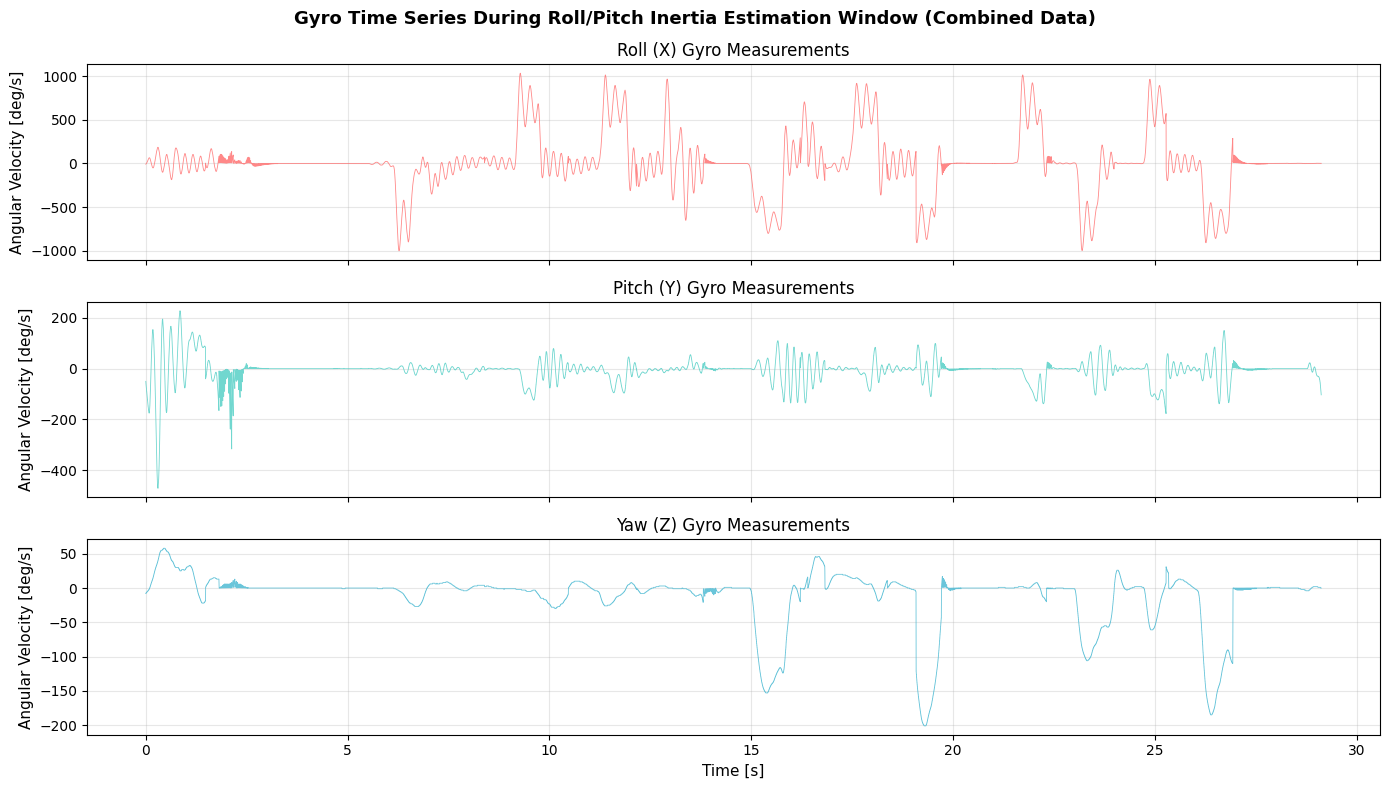

Gyro Statistics (combined roll/pitch inertia data):
Roll (X):
  Min: -999.00 deg/s
  Max: 1032.00 deg/s
  Mean: 5.76 deg/s
  Std Dev: 319.93 deg/s
Pitch (Y):
  Min: -471.00 deg/s
  Max: 228.00 deg/s
  Mean: -7.51 deg/s
  Std Dev: 49.32 deg/s
Yaw (Z):
  Min: -201.00 deg/s
  Max: 58.00 deg/s
  Mean: -12.12 deg/s
  Std Dev: 41.22 deg/s


In [161]:
# Plot gyro time series for roll/pitch inertia estimation window
fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

axis_names = ['Roll (X)', 'Pitch (Y)', 'Yaw (Z)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for axis_i in range(3):
    ax = axs[axis_i]
    
    # Plot combined data directly
    omega = combined_inertia_roll_pitch["omega"][:, axis_i]
    timestamps = np.arange(len(omega)) / 1988.1  # Using the frequency we observed
    
    # Convert from rad/s to deg/s
    omega_deg = omega * (180 / np.pi)
    
    ax.plot(timestamps, omega_deg, alpha=0.8, linewidth=0.6, color=colors[axis_i])
    
    ax.set_ylabel(f'Angular Velocity [deg/s]', fontsize=11)
    ax.set_title(f'{axis_names[axis_i]} Gyro Measurements', fontsize=12)
    ax.grid(True, alpha=0.3)

axs[-1].set_xlabel('Time [s]', fontsize=11)
fig.suptitle('Gyro Time Series During Roll/Pitch Inertia Estimation Window (Combined Data)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"figures/{model_name}_gyro_timeseries.png", dpi=dpi)
plt.show()

# Print some stats
print("Gyro Statistics (combined roll/pitch inertia data):")
print("="*60)
for axis_i in range(3):
    omega = combined_inertia_roll_pitch["omega"][:, axis_i] * (180 / np.pi)  # Convert to deg/s
    
    print(f"{axis_names[axis_i]}:")
    print(f"  Min: {omega.min():.2f} deg/s")
    print(f"  Max: {omega.max():.2f} deg/s")
    print(f"  Mean: {omega.mean():.2f} deg/s")
    print(f"  Std Dev: {omega.std():.2f} deg/s")
print("="*60)

I_x (Roll): 9.943932e-06 kg*m^2
  Inliers: 38607/57898 (66.7%)

I_y (Pitch): 9.499339e-06 kg*m^2
  Inliers: 22056/57898 (38.1%)



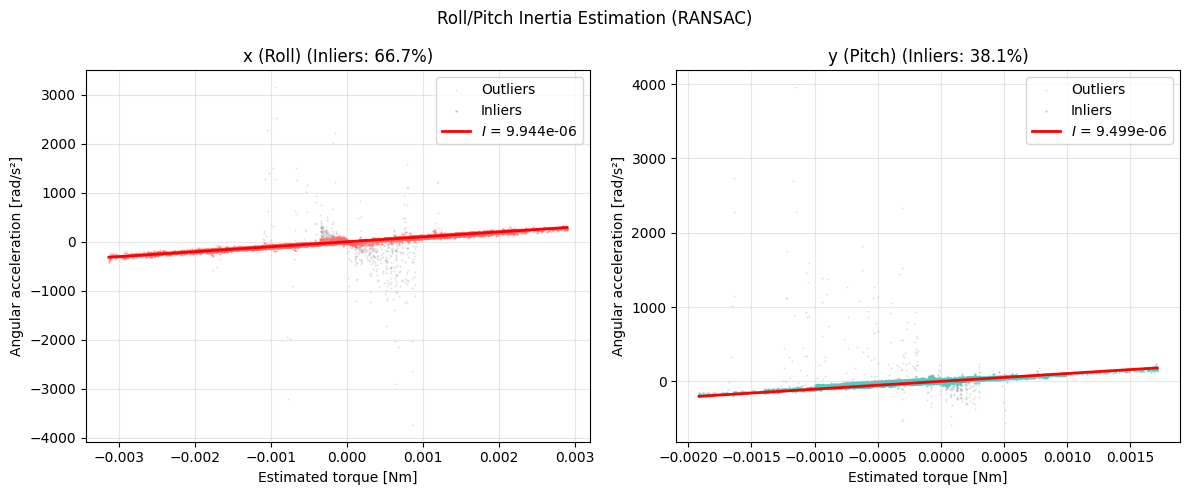

In [162]:
I = []
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for axis_i, axis_name in zip([0, 1], ["x (Roll)", "y (Pitch)"]):
    ax = axs[axis_i]
    dw_full = combined_inertia_roll_pitch["domega"][:, axis_i]
    torque_full = combined_inertia_roll_pitch["pre_torque_geometric"].sum(axis=1)[:, axis_i]

    # Use RANSAC for robust inertia estimation
    I_axis, inliers_mask, inlier_ratio = estimate_inertia_ransac(
        dw_full, torque_full,
        iterations=1000,
        threshold_factor=2.5,
        min_alpha=1e-2  # Ignore accelerations < 1e-2 rad/s² (very low excitation)
    )

    print(f"I_{axis_name}: {I_axis:.6e} kg*m^2")
    print(f"  Inliers: {inliers_mask.sum()}/{len(dw_full)} ({inlier_ratio*100:.1f}%)")
    print()

    # Plot all data (gray) and inliers (colored)
    ax.scatter(torque_full[~inliers_mask], dw_full[~inliers_mask],
               s=0.3, alpha=0.2, color='gray', label='Outliers')
    ax.scatter(torque_full[inliers_mask], dw_full[inliers_mask],
               s=0.5, alpha=0.5, color='#FF6B6B' if axis_i == 0 else '#4ECDC4', 
               label='Inliers')

    # Plot fitted line
    if max(np.abs(torque_full)) > 0:
        torques_range = np.linspace(torque_full.min(), torque_full.max(), 100)
        ax.plot(torques_range, torques_range / I_axis, color="red",
                linewidth=2, label=f"$I$ = {I_axis:.3e}")

    ax.set_xlabel(f"Estimated torque [Nm]")
    ax.set_ylabel(f"Angular acceleration [rad/s²]")
    ax.set_title(f"{axis_name} (Inliers: {inlier_ratio*100:.1f}%)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    I.append(I_axis)

fig.suptitle("Roll/Pitch Inertia Estimation (RANSAC)")
fig.tight_layout()
fig.savefig(f"figures/{model_name}_inertia_roll_pitch.png", dpi=dpi)
plt.show()

In [163]:
# Calculate yaw inertia from roll/pitch using ratio
I_xx, I_yy = I[:2]
I_zz = (I_xx + I_yy) / 2 * inertia_ratio
I = [I_xx, I_yy, I_zz]

print(f"I_xx: {I_xx:.6e} kg*m^2")
print(f"I_yy: {I_yy:.6e} kg*m^2") 
print(f"I_zz: {I_zz:.6e} kg*m^2 (estimated using ratio {inertia_ratio})")

I_xx: 9.943932e-06 kg*m^2
I_yy: 9.499339e-06 kg*m^2
I_zz: 1.749894e-05 kg*m^2 (estimated using ratio 1.8)


## Step 7: Estimate Torque Constant (K_tau)

K_tau: 4.208960e-03


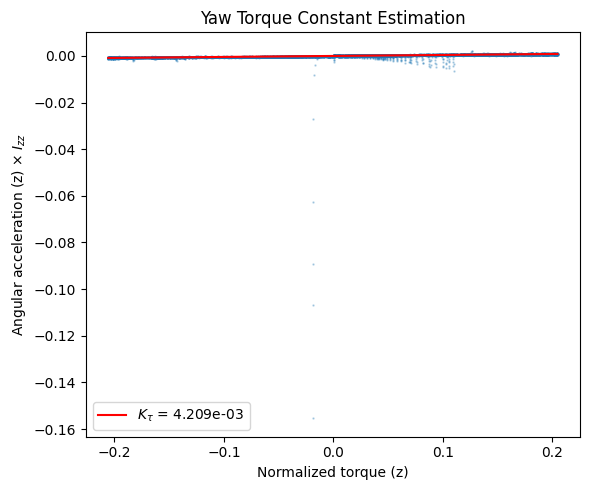

In [164]:
# Estimate yaw torque constant
thrust_torques_inputs = combined_inertia_yaw["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
thrust_torque_inputs_z = thrust_torques_inputs[:, :, 2].sum(axis=1)
dwz = combined_inertia_yaw["domega"][:, 2]

b = dwz * I_zz
K_tau = 1 / (thrust_torque_inputs_z**2).sum() * np.inner(thrust_torque_inputs_z, b)

print(f"K_tau: {K_tau:.6e}")

plt.figure(figsize=(6, 5))
plt.scatter(thrust_torque_inputs_z, b, s=0.5, alpha=0.3)
x_range = np.linspace(thrust_torque_inputs_z.min(), thrust_torque_inputs_z.max(), 100)
plt.plot(x_range, K_tau * x_range, color="red", 
         label=f"$K_\\tau$ = {K_tau:.3e}")
plt.ylabel(f"Angular acceleration (z) × $I_{{zz}}$")
plt.xlabel(f"Normalized torque (z)")
plt.legend()
plt.title("Yaw Torque Constant Estimation")
plt.tight_layout()
plt.savefig(f"figures/{model_name}_K_tau.png", dpi=dpi)
plt.show()

## Step 8: Generate Output JSON

In [165]:
# Build final parameters dictionary
initial_keys = ['mass', 'rotor_positions', 'rotor_thrust_directions', 'rotor_torque_directions']

parameters = {
    **{key: model[key].tolist() if isinstance(model[key], np.ndarray) else model[key] for key in initial_keys},
    "thrust_coefficients": [K_f_mean.tolist()] * 4,
    "rotor_torque_constants": [float(K_tau)] * 4,
    "inertia_diag": [
        float(I_xx),
        float(I_yy),
        float(I_zz)
    ],
    "delay_rising_constants": [float(T_m_rising)] * 4,
    "delay_falling_constants": [float(T_m_falling)] * 4
}

# Add max measured RPM if available
if has_rpm_data and max_measured_rpm is not None:
    parameters["max_measured_rpm"] = float(max_measured_rpm)

print("System Identification Parameters:")
print("=" * 50)
print(json.dumps(parameters, indent=4))

System Identification Parameters:
{
    "mass": 0.036,
    "rotor_positions": [
        [
            -0.028000000000000004,
            -0.028,
            0.0
        ],
        [
            0.028000000000000004,
            -0.028,
            0.0
        ],
        [
            -0.028000000000000004,
            0.028,
            0.0
        ],
        [
            0.028000000000000004,
            0.028,
            0.0
        ]
    ],
    "rotor_thrust_directions": [
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            1
        ]
    ],
    "rotor_torque_directions": [
        [
            0,
            0,
            1
        ],
        [
            0,
            0,
            -1
        ],
        [
            0,
            0,
            -1
        ],
        [
           

In [166]:
# Save to JSON file
output_file = f"{model_name}_parameters.json"
with open(output_file, 'w') as f:
    json.dump(parameters, f, indent=4)

print(f"\nParameters saved to: {output_file}")


Parameters saved to: my_quad_parameters.json


<cell_type>markdown</cell_type>## Step 9: Calculate TWR and Max Angular Acceleration

Calculate the thrust-to-weight ratio at max motor RPM and maximum angular acceleration for each axis.

PERFORMANCE METRICS

Max Motor RPM: 21679
Thrust per motor at max RPM: 0.124977 N
Total thrust at max RPM: 0.499908 N

Mass: 0.0360 kg
Weight: 0.353160 N
TWR at max RPM: 1.42

Inertia (diagonal):
  I_xx: 9.943932e-06 kg*m²
  I_yy: 9.499339e-06 kg*m²
  I_zz: 1.749894e-05 kg*m²
  K_tau: 4.208960e-03

Rotor positions:
  Motor 0: [-0.028 -0.028  0.   ]
  Motor 1: [ 0.028 -0.028  0.   ]
  Motor 2: [-0.028  0.028  0.   ]
  Motor 3: [0.028 0.028 0.   ]

Moment arms:
  X (for pitch): 0.0280 m
  Y (for roll): 0.0280 m
  Max torque (roll): 0.006999 Nm
  Max torque (pitch): 0.006999 Nm

Max angular acceleration:
  Roll (around x-axis): 40325.76 deg/s²
  Pitch (around y-axis): 42213.10 deg/s²
  Yaw (around z-axis): 3444.65 deg/s²



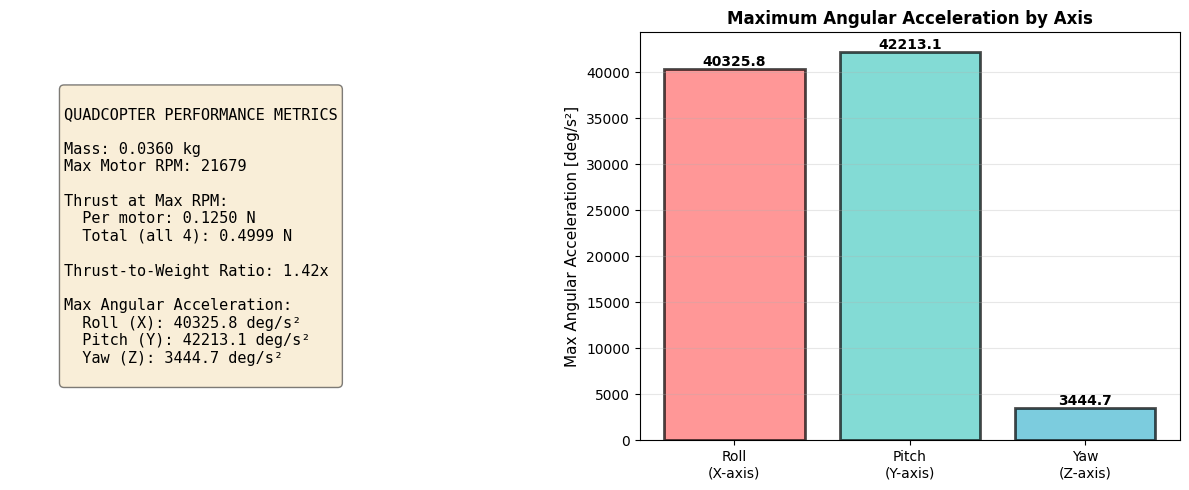

In [167]:
# Calculate thrust at max motor RPM using the final thrust curve
K_f = parameters["thrust_coefficients"][0]  # All motors have same coefficients
max_rpm = parameters.get("max_measured_rpm", 21677)

print("="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(f"\nMax Motor RPM: {max_rpm:.0f}")

# Calculate thrust per motor at max RPM
thrust_per_motor_at_max_rpm = sum(K_f[exp] * (max_rpm ** exp) for exp in range(len(K_f)))
print(f"Thrust per motor at max RPM: {thrust_per_motor_at_max_rpm:.6f} N")

# Total thrust at max RPM (all 4 motors at max)
total_thrust_at_max_rpm = thrust_per_motor_at_max_rpm * 4
print(f"Total thrust at max RPM: {total_thrust_at_max_rpm:.6f} N")

# Thrust-to-Weight Ratio
mass = parameters["mass"]
gravity = 9.81
weight = mass * gravity
twr = total_thrust_at_max_rpm / weight

print(f"\nMass: {mass:.4f} kg")
print(f"Weight: {weight:.6f} N")
print(f"TWR at max RPM: {twr:.2f}")

# Calculate max angular acceleration for each axis
I_xx = parameters["inertia_diag"][0]
I_yy = parameters["inertia_diag"][1]
I_zz = parameters["inertia_diag"][2]
K_tau = parameters["rotor_torque_constants"][0]

print(f"\nInertia (diagonal):")
print(f"  I_xx: {I_xx:.6e} kg*m²")
print(f"  I_yy: {I_yy:.6e} kg*m²")
print(f"  I_zz: {I_zz:.6e} kg*m²")
print(f"  K_tau: {K_tau:.6e}")

# Use actual rotor positions from the model
rotor_positions = np.array(parameters["rotor_positions"])
print(f"\nRotor positions:")
for i, pos in enumerate(rotor_positions):
    print(f"  Motor {i}: {pos}")

# Calculate torque for each axis using actual motor positions
# For roll/pitch: torque = cross product of rotor position and thrust direction
# Maximum torque occurs when we have maximum thrust differential between opposite motors

# For ROLL (X-axis): moments from Y positions
# Torque_x = sum(r_y * F_z) for each rotor
# Max occurs when front motors at max, rear at zero (or vice versa)
# τ_roll_max = |r_y[0]| * 2 * thrust_max
y_positions = rotor_positions[:, 1]
max_y_moment_arm = np.max(np.abs(y_positions))
max_torque_roll = max_y_moment_arm * 2 * thrust_per_motor_at_max_rpm
max_angular_accel_roll = (max_torque_roll / I_xx) * (180 / np.pi)  # Convert to deg/s²

# For PITCH (Y-axis): moments from X positions
# Torque_y = sum(r_x * F_z) for each rotor
# Max occurs when right motors at max, left at zero (or vice versa)
# τ_pitch_max = |r_x[0]| * 2 * thrust_max
x_positions = rotor_positions[:, 0]
max_x_moment_arm = np.max(np.abs(x_positions))
max_torque_pitch = max_x_moment_arm * 2 * thrust_per_motor_at_max_rpm
max_angular_accel_pitch = (max_torque_pitch / I_yy) * (180 / np.pi)  # Convert to deg/s²

print(f"\nMoment arms:")
print(f"  X (for pitch): {max_x_moment_arm:.4f} m")
print(f"  Y (for roll): {max_y_moment_arm:.4f} m")
print(f"  Max torque (roll): {max_torque_roll:.6f} Nm")
print(f"  Max torque (pitch): {max_torque_pitch:.6f} Nm")

print(f"\nMax angular acceleration:")
print(f"  Roll (around x-axis): {max_angular_accel_roll:.2f} deg/s²")
print(f"  Pitch (around y-axis): {max_angular_accel_pitch:.2f} deg/s²")

# For yaw: all 4 motors contribute to yaw torque via K_tau
# τ_yaw = K_tau * (thrust_1 - thrust_2 + thrust_3 - thrust_4)
# With motor layout, max yaw torque ≈ 2 * K_tau * thrust_max
max_torque_yaw = 2 * K_tau * thrust_per_motor_at_max_rpm
max_angular_accel_yaw = (max_torque_yaw / I_zz) * (180 / np.pi)  # Convert to deg/s²

print(f"  Yaw (around z-axis): {max_angular_accel_yaw:.2f} deg/s²")

print("\n" + "="*60)

# Create a summary visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Performance metrics summary
ax = axs[0]
ax.axis('off')
metrics_text = f"""
QUADCOPTER PERFORMANCE METRICS

Mass: {mass:.4f} kg
Max Motor RPM: {max_rpm:.0f}

Thrust at Max RPM:
  Per motor: {thrust_per_motor_at_max_rpm:.4f} N
  Total (all 4): {total_thrust_at_max_rpm:.4f} N

Thrust-to-Weight Ratio: {twr:.2f}x

Max Angular Acceleration:
  Roll (X): {max_angular_accel_roll:.1f} deg/s²
  Pitch (Y): {max_angular_accel_pitch:.1f} deg/s²
  Yaw (Z): {max_angular_accel_yaw:.1f} deg/s²
"""
ax.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Angular acceleration by axis bar chart
ax = axs[1]
axes_names = ['Roll\n(X-axis)', 'Pitch\n(Y-axis)', 'Yaw\n(Z-axis)']
accel_values = [max_angular_accel_roll, max_angular_accel_pitch, max_angular_accel_yaw]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax.bar(axes_names, accel_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Max Angular Acceleration [deg/s²]', fontsize=11)
ax.set_title('Maximum Angular Acceleration by Axis', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, accel_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"figures/{model_name}_performance_metrics.png", dpi=dpi)
plt.show()